# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 
Необходимо построить модель для решения задачи регрессиии: определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

In [27]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

RS=17

## Подготовка данных

### Знакомство с данными

In [12]:
try:
    df = pd.read_csv('datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [13]:
df.shape

(354369, 16)

In [14]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Сразу же выполним переименование столбцов в змеиный регистр для удобства работы.

In [15]:
for name in df.columns:
    new_name = re.sub(r"(?=[A-Z])(?!^)", '_', name).lower()
    df = df.rename(columns={name:new_name})

Преобразуем столбцы с датой в тип `datetime`.

In [16]:
dates = ['date_crawled', 'date_created', 'last_seen']
for date in dates:
    df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H:%M:%S')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [18]:
df.describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
first,2016-03-05 14:06:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-10 00:00:00,NaN,NaN,2016-03-05 14:15:08
last,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,NaN,NaN,2016-04-07 14:58:51
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN


Так как столбец с количеством фотографий содержит нули для каждого объявления - удалим его.

In [19]:
df.drop('number_of_pictures', axis=1, inplace=True)

**Познакомимся с брендами**

In [20]:
print(f'Уникальных брендов автомобилей в датасете:', len(df['brand'].unique()))

Уникальных брендов автомобилей в датасете: 40


Преобразуем признак бренда в категориальный тип данных чтобы было удобно построить наглядную гистограмму.

In [21]:
df['brand'] = pd.Categorical(values=df['brand'],
                             categories=list(df['brand'].value_counts().index)
)

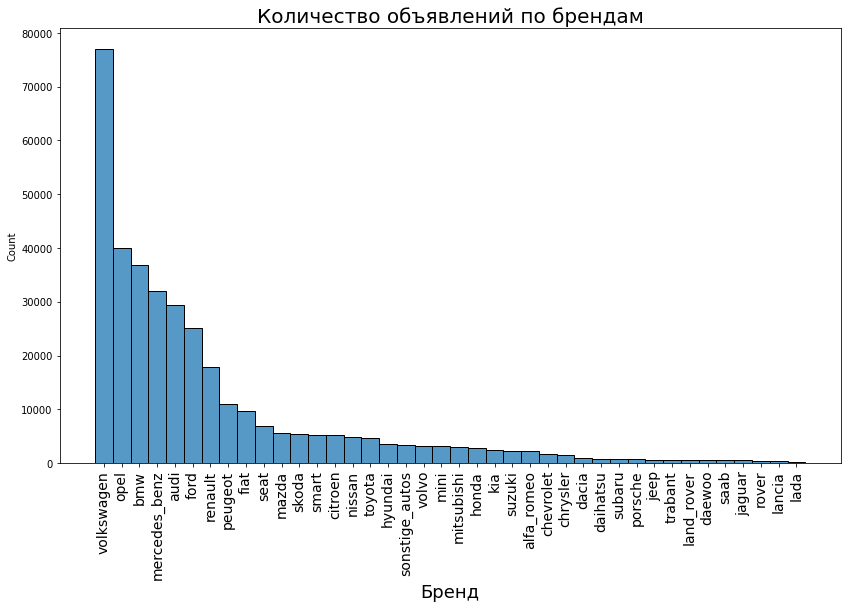

In [22]:
plt.figure(figsize=(14,8))
sns.histplot(df['brand'])
plt.title('Количество объявлений по брендам', fontsize=20)
plt.xlabel('Бренд', fontsize=18)
plt.xticks(rotation=90, fontsize=14);

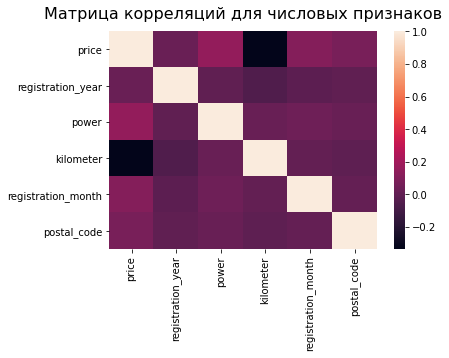

In [26]:
sns.heatmap(df.corr())
plt.title('Матрица корреляций для числовых признаков', fontsize=16, y=1.03);

#### Вывод

**Исследовательский анализ данных**
* У нас 354 тыс. наблюдений и 16 признаков;
* Данные выгружались в период с 5 марта 2016 по 7 апреля 2016 (~1 месяц);
* Объявления созданы с 10 марта ***2014*** по 7 апреля 2016 (~2 года);
* Последняя активность владельца объявления приходится на период с 5 марта 2016 (*ограничено датой выгрузки данных*) по 7 апреля 2016 (~1 месяц);
* В признаке `price` нет пропусков, но присутствуют нулевые значения и их довольно много судя по искажению среднего относительно медианы;
* В признаке `vehicle_type` 8 уникальных значений и около 10% пропусков;
* `registration_year` имеет небольшое количество аномальных значений;
* 80% автомобилей имеют ручную коробку передач, пропусков по этому признаку около 5%;
* Признак `power` в целом выглядит неплохо, но есть + и - выбросы, в т.ч. нулевые значения;
* 250 уникальных моделей авто и 5% пропусков в признаке `model`;
* В признаке `kilometer` странным образом равны медиана, третий квартиль и максимальное значение. Вероятно, форма объявления на сайте не позволяет указать значение более 150 тыс. км., при этом более половины автомобилей имеют пробег больше;
* В признаке `registration_month` всё в порядке, кроме нулевых значений;
* У автомобилей 7 видов топлива и 10% пропусков в `fuel_type`;
* По признаку `not_repaired` большинство машин не были в ремонте, но имеем около 20% пропусков;
* Признак `number_of_pictures` заполнен нулями, удалим его;
* `postal_code` не имеет пропусков и может быть полезен как признак региона объявления.

**Визуализации данных:**
* Наиболее распространены в этой выборке машины бренда Фольксваген. Далее с отставанием более чем в 2 раза по количеству объявлений: Опель, БМВ, Мерседес-Бенц, Ауди, Форд, Рено;
* Матрица корреляции показала отсутствие сильных взаимосвязей между количественными переменными датасета.

### Предобработка данных

Сперва избавимся от явных дубликатов.

In [87]:
df.duplicated().sum()

4

In [88]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

**Цена** - наш целевой признак для обучения модели регрессии.
Посмотрим, сколько у нас объявлений с нереалистичной ценой: скажем, менее 100 евро.

In [89]:
df[df['price'] < 100].shape[0]

13314

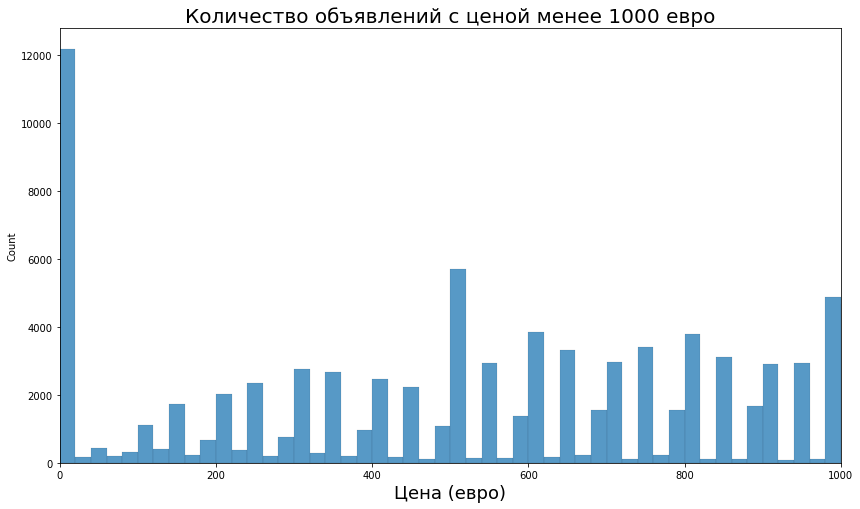

In [90]:
plt.figure(figsize=(14,8))
sns.histplot(df['price'], bins=1000)
plt.xlim((0,1000))
plt.title('Количество объявлений с ценой менее 1000 евро', fontsize=20)
plt.xlabel('Цена (евро)', fontsize=18);

Наибольший вклад в аномальные значения цены на срезе датасета с объявлениями дешевле 100 евро вносят публикации с нулевой ценой - их более 12 тысяч. К сожалению, мы не сможем использовать такие наблюдения в обучении моделей регрессии поэтому придется удалить их.

In [91]:
df = df.loc[~(df['price'] == 0)].reset_index(drop=True)

**Мощность двигателя**

Изучим более подробно на предмет аномалий и выбросов.

Нулевые значения заменим на NaN - обработаем их при заполнении пропусков.

In [92]:
df.loc[(df['power'] == 0), 'power'] = np.nan

Взглянем на оставшиеся выбросы - возьмем диапазон нереалистичных значений, скажем менее 30 и более 600 л.с.

In [93]:
df.query('power < 30 or power > 600').shape

(1220, 15)

Даже если в этих данных прекрасные раритетные автомобили или невероятные спорткары - безжалостно удалим их, так как слишком мало данных, чтобы модель хорошо научилась предсказывать цену для таких редких представителей своего класса, но вот испортить качество предсказаний они могут.

In [94]:
df = df.loc[~((df['power'] < 30) | (df['power'] > 600))].reset_index(drop=True)

**Месяц регистрации**

In [95]:
df.query('registration_month == 0').shape

(32688, 15)

Целых 10% данных заполнены нулём в качестве месяца регистрации. Скорее всего этот признак нам не понадобится в обучении, но пока что заменим на NaN, чтобы обработать вместе с пропусками.

In [96]:
df.loc[(df['registration_month'] == 0), 'registration_month'] = np.nan

**Год регистрации**

Посчитаем, сколько у нас наблюдений с годом регистрации, выходящим за реалистичные значения для конкретных данных (1910-2016)

In [97]:
df.query('registration_year <= 1910 or registration_year > 2016').shape

(13831, 15)

In [98]:
df.query('registration_year > 2016').shape

(13733, 15)

Почти все выбросы в дате регистрации автомобиля находятся в промежутке 2016-2018 гг. Вероятно, это может быть какая-то ошибка пользователей при заполнении, например, могли перепутать с датой окончания страховки или что-то подобное. Интуитиво кажется, что этот признак может быть супер важным для обучения, так как он скорее всего коррелирует с годом выпуска автомобиля.

И пусть речь идёт всего о 4% данных, мы предпочтем их оставить. Удалим только несколько объектов, с годом регистрации до 1950 и после 2018 годов.

In [99]:
df = df.loc[(df['registration_year'] > 1950) & 
            (df['registration_year'] <= 2018), :].reset_index(drop=True)

**Изменение типов данных для категориальных признаков**

In [100]:
obj_cols = [col for col in df.columns if df[col].dtype == 'O']
df[obj_cols] = df[obj_cols].astype('category')

### Обработка пропусков


В датасете присутствуют пропуски в столбцах:
* `vehicle_type`
* `gearbox`
* `power` *(единственный числовой)*
* `model`
* `registration_month`
* `fuel_type`

In [102]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          33425
registration_year         0
gearbox               17091
power                 36164
model                 17108
kilometer                 0
registration_month    32523
fuel_type             29106
brand                     0
not_repaired          65326
date_created              0
postal_code               0
last_seen                 0
dtype: int64

**Тип кузова**

Посмотрим, какие типы кузова у нас представлены.

In [103]:
df['vehicle_type'].value_counts(dropna=False)

sedan          89111
small          77596
wagon          63568
NaN            33425
bus            28300
convertible    19779
coupe          15596
suv            11754
other           2980
Name: vehicle_type, dtype: int64

**Ремонтирован ли автомобиль**

In [104]:
print('Доли машин по отношению к ремонту')
df['not_repaired'].value_counts(normalize=True, dropna=False)

Доли машин по отношению к ремонту


no     0.709987
NaN    0.190951
yes    0.099062
Name: not_repaired, dtype: float64

70% автомобилей никогда не ремонтировались, 10% ремонтировались и 20% неизвестно.

Будем считать, что если пользователь не указал ничего, то машина не была в ремонте, поэтому заполним пропуски значением "no".

In [105]:
df['not_repaired'].fillna('no', inplace=True)

**Коробка передач**

In [106]:
print('Доли машин с разными коробками передач')
df['gearbox'].value_counts(normalize=True, dropna=False)

Доли машин с разными коробками передач


manual    0.761181
auto      0.188861
NaN       0.049958
Name: gearbox, dtype: float64

#### Заполнение пропусков

Отбросим признаки, которые в дальнейшем не будем использовать: 
* даты (дата выгрузки данных, дата публикации объявления, дата последнего просмотра объявления);
* месяц регистрации (у нас есть год и он важнее);
* почтовый индекс (предположим, в центральных регионах больше спрос на автомобили, но чтобы правильно использовать такой признак в обучении нам придется создать почти 100 тыс. дополнительным столбцов при One-Hot-Encoding, потому что это категориальный, а не числовой призанк).

In [107]:
df_clear = df.drop(dates + ['registration_month', 'postal_code'], axis=1)

In [108]:
df_clear.shape

(342109, 10)

Осталось 10 признаков: 6 категориальных и 4 числовых.

In [109]:
df_clear.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,NaN,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no


При заполнении пропусков нам понадобятся имена числовых и категориальных столбцов нашего датасета.

In [110]:
num_cols = [col for col in df_clear.columns if df_clear[col].dtype.name != 'category']
cat_cols = [col for col in df_clear.columns if df_clear[col].dtype.name == 'category']

Так как пропуски хочется заполнить с максимальным сохранением ценности данных - воспользуемся любимым машинным обучением.
* для заполнения пропусков в числовых столбцах прибегнем к специальному итеративному "заполнятелю", в основу которого положим алгоритм случайного леса для регрессии;
* для заполнения пропусков в категориальных столбцах воспользуемся методом k-ближайших соседей.

In [112]:
imp_num = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, 
                                                           max_depth=5,
                                                           bootstrap=True,
                                                           n_jobs=-1),
                           initial_strategy='mean',
                           max_iter=10, random_state=RS, verbose=1)

In [113]:
%%time
df_final_num = pd.DataFrame(imp_num.fit_transform(df_clear[num_cols]), columns=num_cols)

[IterativeImputer] Completing matrix with shape (342109, 4)
[IterativeImputer] Change: 113.70164728965096, scaled tolerance: 150.0 
[IterativeImputer] Early stopping criterion reached.
CPU times: user 4.79 s, sys: 0 ns, total: 4.79 s
Wall time: 4.79 s


Для передачи наших категориальных признаков нам понадобится небольшая функция, задача которой преобразовать текстовые поля в числа. В основе этой функции лежит класс `LabelEncoder` из библиотеки `sklearn`, но в нашем решении есть еще две фичи:
1. Для каждого столбца мы обучаем отдельный экземпляр класса `LabelEncoder`, который храним в экземпляре класса `defaultdict` из встроенного Python-модуля `Collections`. Это необходимо чтобы в дальнейшем можно было инвертировать кодировку наших категориальных признаков и вернуть им человекочитаемый вид;
2. Мы сохраняем в виде `NaN` пропуски в столбцах, чтобы `KNNImputer` смог их заполнить. Ограничиваем гиперпараметр количество соседей до одного.


In [114]:
d = defaultdict(LabelEncoder)

def lab_enc_with_nan(series):
    series_encoded = pd.Series(
        data=d[series.name].fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    )
    return series_encoded

In [115]:
# применяем функцию к каждой строке датафрейма
df_final_cat = df_clear[cat_cols].apply(lab_enc_with_nan)

In [116]:
df_final_cat.head()

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,NaN,1.0,116.0,6.0,38,0
1,2.0,1.0,NaN,2.0,1,1
2,6.0,0.0,117.0,2.0,14,0
3,5.0,1.0,116.0,6.0,38,0
4,5.0,1.0,101.0,2.0,31,0


In [117]:
%%time
imputer = KNNImputer(n_neighbors=1)
df_final_cat = imputer.fit_transform(df_final_cat)

CPU times: user 21min 20s, sys: 9min 31s, total: 30min 51s
Wall time: 30min 53s


In [118]:
df_final_cat = pd.DataFrame(df_final_cat, columns=cat_cols)
df_final_cat.head()

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,5.0,1.0,116.0,6.0,38.0,0.0
1,2.0,1.0,29.0,2.0,1.0,1.0
2,6.0,0.0,117.0,2.0,14.0,0.0
3,5.0,1.0,116.0,6.0,38.0,0.0
4,5.0,1.0,101.0,2.0,31.0,0.0


In [119]:
# чтобы энкодер нас правильно понял float возвращаем в int
df_final_cat = df_final_cat.astype('int')

# обращаем кодировку, переходя обратно к текстовому виду
df_final_cat = df_final_cat.apply(lambda x: d[x.name].inverse_transform(x))

Наконец, объединим наши датафреймы без пропусков в один -- `df_final`.

In [120]:
df_final = pd.concat([df_final_num, df_final_cat], axis=1)
df_final.shape

(342109, 10)

### Подготовка выборок для обучения

In [121]:
X, y = df_final.drop('price', axis=1), df_final['price']

Для линейной регрессии, RF-регрессора и XGBoost нам нужно применить OHE для категориальных признаков.

In [122]:
X = pd.concat(
    [X.drop(cat_cols, axis=1),
    pd.get_dummies(X[cat_cols], drop_first=True)],
    axis=1
)
X.shape

(342109, 306)

Данных у нас предостаточно, поэтому на тест модели отложим только 20% исходного датасета.

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

Линейная модель чувствительна к масштабу признаков, поэтому ради неё выполним стандартизацию **числовых** признаков.

In [124]:
scaler = StandardScaler() 

num_cols.remove('price')

X_train[num_cols] = scaler.fit_transform(X_train[num_cols]) 
X_test[num_cols] = scaler.transform(X_test[num_cols]) 

## Обучение моделей

В этом проекте мы выполним обучение и сравнение следующих моделей:
* Linreg, 
* RFregressor, 
* XGB, 
* LightGBM, 
* CatBoost.

Так как заказчику помимо метрики качества важны скорость обучения и скорость предскзания модели, то для соответствующих ячеек будем измерять время выполнения.

Модели будем обучать и оценивать с помощью метрики RMSE (Root Mean Square Error, cреднеквадратичная ошибка). Результаты будем сохранять в отдельном маленьком датафрейме для последующего сравнения.

In [125]:
results = pd.DataFrame(index=['RMSE_train', 'RMSE_test'])

### Линейная регрессия

In [126]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [127]:
results['lin_reg'] = [mean_squared_error(y_train, lr.predict(X_train), squared=False),
                      mean_squared_error(y_test, lr.predict(X_test), squared=False)]

In [128]:
round(results)

,lin_reg
RMSE_train,2747.0
RMSE_test,2748.0


### RFregressor

In [129]:
%%time
rf_reg = RandomForestRegressor(n_estimators=100, 
                               max_depth=7, 
                               max_features=1.0,
                               n_jobs=-1, random_state=RS)
rf_reg.fit(X_train, y_train)

CPU times: user 4min 2s, sys: 1.85 s, total: 4min 3s
Wall time: 4min 4s


RandomForestRegressor(max_depth=7, max_features=1.0, n_jobs=-1, random_state=17)

In [130]:
results['rf_reg'] = [mean_squared_error(y_train, rf_reg.predict(X_train), squared=False),
                      mean_squared_error(y_test, rf_reg.predict(X_test), squared=False)]

In [131]:
round(results)

,lin_reg,rf_reg
RMSE_train,2747.0,2132.0
RMSE_test,2748.0,2137.0


### XGBoost

In [132]:
%%time
param = {
#     'max_depth':6, # глубина дерева, по умолчанию 6
#     'eta':0.3, # шаг градиента, лучше 0.01-0.2 
#     'min_child_weight':1, # потомков в узле,
    'objective':'reg:squarederror'}
num_round = 100

dtrain = xgb.DMatrix(X_train, y_train)
model_xgb = xgb.train(param, dtrain, num_round)

CPU times: user 7min 18s, sys: 0 ns, total: 7min 18s
Wall time: 7min 21s


In [133]:
results['XGB'] = [mean_squared_error(y_train, model_xgb.predict(xgb.DMatrix(X_train)), squared=False),
                  mean_squared_error(y_test, model_xgb.predict(xgb.DMatrix(X_test)), squared=False)]

In [134]:
round(results)

,lin_reg,rf_reg,XGB
RMSE_train,2747.0,2132.0,1601.0
RMSE_test,2748.0,2137.0,1663.0


Взглянем на топ-30 признаков, которые бустинг чаще всего использовал в своих узлах для разделения наблюдений. 

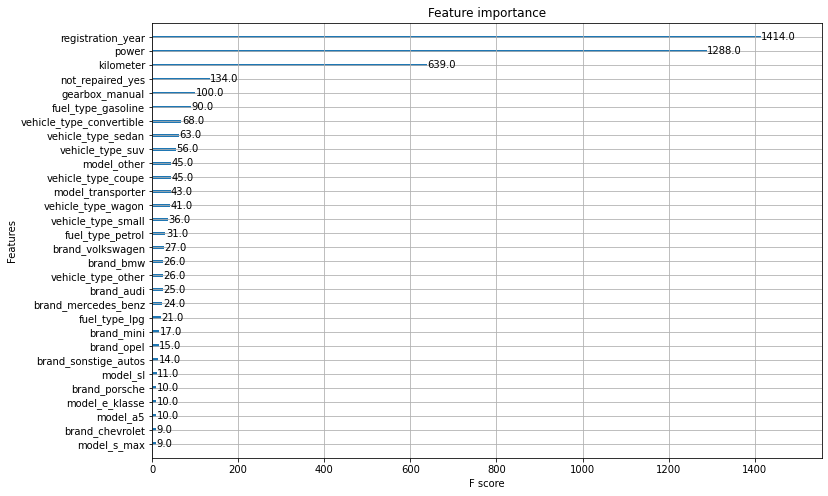

In [138]:
ax = xgb.plot_importance(model_xgb, max_num_features=30)
fig = ax.figure
fig.set_size_inches(12, 8);

#### Вывод

* После небольшого тюнинга основных параметров было решено остановиться на дефолтных параметрах, так как они показали наилучшее качество:
    * RMSE = 1600 на обучающей выборке и 1663 на тестовой.
* В качестве наиболее важных признаков для обучения модель выделила:
    1. Год регистрации
    2. Мощность двигателя
    3. Пробег
    4. Отсутвие ремонта у авто

### LightGBM

In [139]:
train_data = lgb.Dataset(X_train, label=y_train)

In [140]:
param = {
    'objective': 'rmse',
    'num_leaves': 90, 
    'num_threads': 4,
    'learning_rate': 0.1, # default
    'num_iterations': 500,
}

In [141]:
%%time
model_lgb = lgb.train(param, train_data)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 273687, number of used features: 291
[LightGBM] [Info] Start training from score 4560.331090
CPU times: user 19.7 s, sys: 0 ns, total: 19.7 s
Wall time: 19.7 s


In [142]:
%%time
results['LGBM'] = [mean_squared_error(y_train, model_lgb.predict(X_train), squared=False),
                      mean_squared_error(y_test, model_lgb.predict(X_test), squared=False)]

CPU times: user 22.7 s, sys: 0 ns, total: 22.7 s
Wall time: 22.7 s


In [65]:
#default, num_iter=500
round(results)

,lin_reg,rf_reg,XGB,LGBM
RMSE_train,2880.229465,2136.262631,1600.039046,1376.482448
RMSE_test,2889.568298,2140.071653,1671.484855,1530.313204


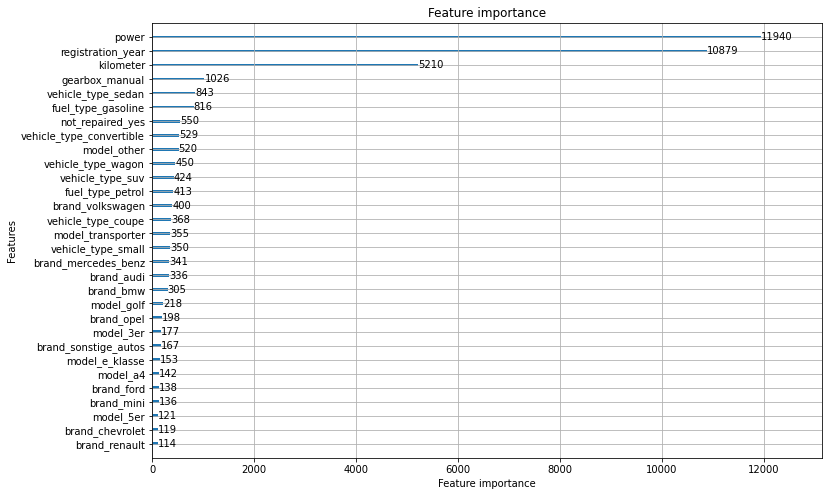

In [143]:
ax = lgb.plot_importance(model_lgb, max_num_features=30)
fig = ax.figure
fig.set_size_inches(12, 8);

#### LightGBM на данных с пропусками

Теперь из любопытства попробуем обучить LightGBM на датасете без заполнения пропусков и без кодирования категориальных признаков с помощью OHE - судя по документации ей это по плечу.

In [144]:
X, y = df_clear.drop('price', axis=1), df_clear['price']
X_train_nan, X_test_nan, y_train_nan, y_test_nan = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

In [145]:
train_data = lgb.Dataset(X_train_nan, label=y_train_nan)

In [146]:
param = {
    'objective': 'rmse',
    'num_threads': 4,
    'learning_rate': 0.1,
    'num_iterations': 500,
}

In [147]:
%%time
model_lgb = lgb.train(param, train_data)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 273687, number of used features: 9
[LightGBM] [Info] Start training from score 4560.331090
CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s


In [148]:
%%time
results['LGBM_with_nan'] = [mean_squared_error(y_train_nan, model_lgb.predict(X_train_nan), squared=False),
                      mean_squared_error(y_test_nan, model_lgb.predict(X_test_nan), squared=False)]

CPU times: user 12.9 s, sys: 0 ns, total: 12.9 s
Wall time: 12.9 s


In [149]:
# default params, num_iter=500
round(results)

,lin_reg,rf_reg,XGB,LGBM,LGBM_with_nan
RMSE_train,2747.0,2132.0,1601.0,1371.0,1487.0
RMSE_test,2748.0,2137.0,1663.0,1528.0,1603.0


#### Вывод
* LightGBM показал наилучшие результаты без тюнинга параметров, только с увеличением количества итераций до 500:
    * RMSE на обучающей выборке 1377, на тестовой 1526.
* В качестве самых важных признаков модель выделила:
    1. Мощность двигателя
    2. Год регистрации
    3. Пробег
    4. Коробка передач - ручная
    5. Тип топлива - бензин
    6. Тип кузова - седан
* Пользуясь возможностями библиотеки LightGBM попробовали обучить бустинг на данных с незаполненными пропусками - результаты получились хуже, но тем не менее, не намного хуже.

### CatBoost

CatBoost работает с категориальными признаками, поэтому для обучения ему передадим наш датафрейм после заполнения пропусков, но до применения One-Hot-Encoding, то есть переменную `df_final`.

In [150]:
X, y = df_final.drop('price', axis=1), df_final['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

In [151]:
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols)

test_pool = Pool(X_test, 
                 cat_features=cat_cols) 

In [152]:
model_cb = CatBoostRegressor(loss_function='RMSE', 
                             random_seed=RS,
                             iterations=2000,
                             learning_rate=0.5,
                             depth=3
                            )

In [153]:
%%time
model_cb.fit(train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3472.9277385	total: 192ms	remaining: 6m 23s
1:	learn: 3002.6189027	total: 304ms	remaining: 5m 3s
2:	learn: 2705.0736862	total: 427ms	remaining: 4m 44s
3:	learn: 2540.3643050	total: 549ms	remaining: 4m 33s
4:	learn: 2396.8279896	total: 654ms	remaining: 4m 20s
5:	learn: 2327.7946458	total: 766ms	remaining: 4m 14s
6:	learn: 2270.6293130	total: 836ms	remaining: 3m 58s
7:	learn: 2235.4711338	total: 929ms	remaining: 3m 51s
8:	learn: 2205.8190449	total: 1.03s	remaining: 3m 49s
9:	learn: 2169.8083610	total: 1.14s	remaining: 3m 46s
10:	learn: 2150.9415049	total: 1.24s	remaining: 3m 44s
11:	learn: 2129.0754658	total: 1.31s	remaining: 3m 37s
12:	learn: 2109.9445004	total: 1.42s	remaining: 3m 36s
13:	learn: 2099.6049032	total: 1.5s	remaining: 3m 32s
14:	learn: 2076.4830028	total: 1.62s	remaining: 3m 34s
15:	learn: 2056.5019278	total: 1.72s	remaining: 3m 33s
16:	learn: 2047.1448820	total: 1.81s	remaining: 3m 31s
17:	learn: 2039.5186957	total: 1.89s	remaining: 3m 27s
18:	learn: 2029.217344

In [154]:
results['CatBoost'] = [mean_squared_error(y_train, model_cb.predict(X_train), squared=False),
                      mean_squared_error(y_test, model_cb.predict(X_test), squared=False)]

In [155]:
round(results)

,lin_reg,rf_reg,XGB,LGBM,LGBM_with_nan,CatBoost
RMSE_train,2747.0,2132.0,1601.0,1371.0,1487.0,1557.0
RMSE_test,2748.0,2137.0,1663.0,1528.0,1603.0,1620.0


In [156]:
pd.DataFrame(data=model_cb.feature_importances_, 
             index=X_train.columns).sort_values(0, ascending=False).T

,registration_year,power,kilometer,brand,vehicle_type,model,not_repaired,fuel_type,gearbox
0,43.006877,33.388993,10.320285,5.27133,2.974236,2.674302,1.145515,1.052066,0.166395


#### Вывод

* После небольшого ручного тюнинга модели, а также перебора по сетке с параметрами `learning_rate` и `depth` не удалось на текущем этапе достичь меньшей ошибки, чем 1600 на тестовой выборке.
* Наибольшую важность для модели представляли такие признаки, как:
    * Мощность двигателя
    * Год регистрации
    * Пробег и бренд авто

## Анализ моделей

В этом проекте мы проанализировали 5 различных алгоритмов машинного обучения из 3-х разных классов (линейная модель, случайный лес, бустинги)
Класс бустингов представляли: XGB, LightGBM, CatBoost.

Результаты обучения лучших представителей каждого алгоритма мы собрали в единую таблицу.

Нашему заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.

В нашем случае лучше других себя показал бустинг LightGBM, достигнув наилучшего качества предсказания на тестовой выборке за меньшее время обучения модели.

Примечательно, что все 3 алгоритма бустинга наиболее часто использовали в своих узлах при построении деревьев такие признаки, как:
* Мощность двигателя;
* Год регистрации;
* Пробег.

In [157]:
round(results)

,lin_reg,rf_reg,XGB,LGBM,LGBM_with_nan,CatBoost
RMSE_train,2747.0,2132.0,1601.0,1371.0,1487.0,1557.0
RMSE_test,2748.0,2137.0,1663.0,1528.0,1603.0,1620.0


## Общий вывод

* Мы получили в работу датасет размером 354 тыс. объявлений о продаже автомобилей по 16 признаков в каждом;
* Данные были выгружены в период с марта по апрель 2016 года;
* Объявления были опубликованы на сервисе с 2014 по 2016 год;
* В данных были пропуски в различных признаках (как в количественных, так и в номинативных). 
    * Пропуски в количественных столбцах были заполнены с помощью класса `IterativeImputer` библиотеки `sklearn`, в качестве алгоритма использовалась модель "случайный лес";
    * Пропуски в номинативных переменных также заполнены с помощью машинного обучения, алгоритм - "метод k-ближайших соседей".
* В обучении участвовало 5 алгоритмов: линейная регрессия, регрессор случайного леса, XGBoost, LightGBM, CatBoost
    * **Наилучший результат по критериям качество предсказания, скорость предсказания и скорость обучения показал бустинг LightGBM** (Метрика качества RMSE на тестовой выборке = 1530 евро);
    * Все алгоритмы бустинга выделили в качестве важных признаков для обучения мощность двигателя, год регистрации и пробег автомобиля.
    
Рекомендуемая модель: LightGBM со стандартными гиперпараметрами и числом итераций 500.